 ### Logistic Regression to Predict Categories (Machine Learning vs. Business Software)

In [ ]:
pwd

In [ ]:
from os import chdir
chdir('/home/jovyan/')

In [4]:
!pip install psycopg2

In [5]:
import library.db_helper as db
import library.functions as fy

In [6]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt
%matplotlib inline

#### Explore my Page Count per Category

In [7]:
query = '''
SELECT * 
FROM category_page;
'''
cat_page_df = db.query_to_dataframe(query)
cat_page_df.shape

(2449, 2)

In [8]:
cat_page_df.sample(5)

,category_cid,page_pid
2149,0,1126158
501,1,36480775
959,0,27208838
1126,0,37789882
777,1,12663005


In [9]:
page_counts_per_cat = cat_page_df.groupby('category_cid').size()

In [10]:
page_count_per_cat_df = pd.DataFrame(page_counts_per_cat).reset_index()\
                                                        .rename(columns={0:"pagecount", 'category_cid':'cid'})

In [12]:
page_count_per_cat_df.sample(2)

,cid,pagecount
1,1,899
0,0,1550


In [13]:
query = '''
SELECT * 
FROM category'''
category_df = db.query_to_dataframe(query)

In [14]:
cid_name_pgcount_df = category_df.merge(page_count_per_cat_df, on='cid', how='left')
cid_name_pgcount_df.sort_values(by='pagecount', ascending=False, inplace=True)

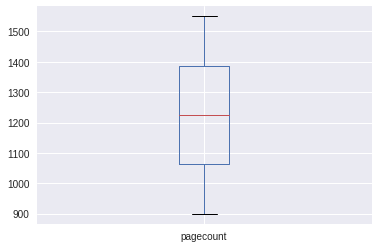

In [18]:
cid_name_pgcount_df.boxplot(column='pagecount')
plt.show()

In [19]:
cid_name_pgcount_df.describe()

,cid,pagecount
count,2.000000,2.000000
mean,0.500000,1224.500000
std,0.707107,460.326515
min,0.000000,899.000000
25%,0.250000,1061.750000
50%,0.500000,1224.500000
75%,0.750000,1387.250000
max,1.000000,1550.000000


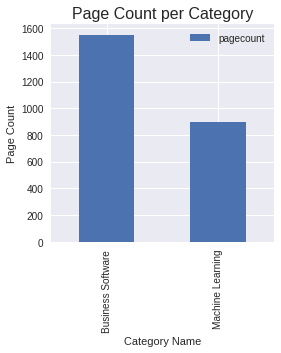

In [27]:
# display a plot to visualize how many pagecounts there are per category (across all 64 categories)
cid_name_pgcount_df[['name', 'pagecount']].plot(x='name', y='pagecount', kind='bar', figsize=(4,4))
plt.xlabel('Category Name')
plt.ylabel('Page Count')
plt.title('Page Count per Category', fontsize=16)
plt.show()

#### Setup a train/test/split

In [30]:
query = '''
SELECT text
FROM page;
'''
X = db.query_to_dataframe(query)
X.shape

(2449, 1)

In [92]:
query = '''
SELECT category_cid
FROM category_page
'''
y = db.query_to_dataframe(query)
y.shape

(2449, 1)

In [93]:
y_vec = (np.array(y).ravel())

In [94]:
y_vec.shape

(2449,)

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X.values.ravel(),y_vec)

#### Train and fit a Classification Model 

In [39]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD

#### Train and fit a model using GridSearchCV

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [41]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report

In [42]:
from sklearn.model_selection import ShuffleSplit

In [49]:
logreg_pipeline = Pipeline([
    ('countvec', CountVectorizer(stop_words='english')),
    ('svd', TruncatedSVD()),
    ('clfr', LogisticRegression()),
])

In [109]:
logreg_params = {
    'countvec__ngram_range':[(1,2)],
    'countvec__min_df':[2],
    'svd__n_components':[400],
}

In [64]:
logreg_gs = GridSearchCV(logreg_pipeline, param_grid=logreg_params, cv=3, n_jobs=-1, verbose=1)

In [65]:
logreg_gs.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('countvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
    ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'countvec__ngram_range': [(1, 2)], 'countvec__min_df': [2], 'svd__n_components': [400]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [67]:
logreg_gs.predict_proba(X_train)

array([[  6.21724894e-15,   1.00000000e+00],
       [  9.94338940e-01,   5.66106001e-03],
       [  0.00000000e+00,   1.00000000e+00],
       ..., 
       [  4.60396082e-02,   9.53960392e-01],
       [  9.99999940e-01,   6.03527284e-08],
       [  9.97534181e-01,   2.46581867e-03]])

In [111]:
logreg_gs.predict(X_train)
# 1 for machine learning
# 0 for business software

array([0, 0, 0, ..., 1, 0, 0])

In [99]:
logreg_gs.score(X_test, y_test)

0.95921696574225124

In [74]:
pd.DataFrame(logreg_gs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_countvec__min_df,param_countvec__ngram_range,param_svd__n_components,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,23.829349,1.378857,0.934641,0.994009,2,"(1, 2)",400,"{'countvec__min_df': 2, 'countvec__ngram_range...",1,0.937908,0.995098,0.926471,0.991013,0.939542,0.995915,4.166098,0.190635,0.005815,0.002144


#### Test on Principal Component Analysis Article as new text

In [ ]:
'https://en.wikipedia.org/wiki/Principal_component_analysis'

In [ ]:
def clean_url (url):
    url.split('/')
        return url[-1]

In [122]:
clean_url('https://en.wikipedia.org/wiki/Logistic_regression')

'Logistic_regression'

In [77]:
# test on NEW data not found in my original data
pca_article = fy.beautify_html_article('Principal_component_analysis')

In [89]:
# note only 145 of my total 2,449 articles contain the word 'pca'
X['text'].str.contains('pca').sum()

145

In [85]:
# the PCA article does not fall into the articles queried from Wikipedia for both
# Machine Learning (1)
# Business Software (0)

pca_clean_article = fy.text_cleaner(pca_article)
pca_newarticle = np.array([pca_clean_article])

In [90]:
logreg_gs.predict(pca_newarticle), logreg_gs.predict_proba(pca_newarticle)
# predicted machine learning for the pca article which is not part of my original data set

(array([1]), array([[ 0.,  1.]]))

#### Test on Logistic Regression Article as new text

In [123]:
logreg_url = 'https://en.wikipedia.org/wiki/Logistic_regression'

In [124]:
logreg_article_name = clean_url(logreg_url)

In [125]:
# test on NEW data not found in my original data
logreg_article = fy.beautify_html_article(logreg_article_name)

In [126]:
# note only 145 of my total 2,449 articles contain the word 'pca'
X['text'].str.contains('logistic regression').sum()

114

In [127]:
# the logreg article does not fall into the articles queried from Wikipedia for both
# Machine Learning (1)
# Business Software (0)

logreg_clean_article = fy.text_cleaner(logreg_article)
logreg_newarticle = np.array([logreg_clean_article])

In [128]:
logreg_gs.predict(logreg_newarticle), logreg_gs.predict_proba(logreg_newarticle)
# predicted machine learning for the pca article which is not part of my original data set

(array([1]), array([[ 0.,  1.]]))

#### Test on Logistic Regression Article as new text

In [129]:
erp_url = 'https://en.wikipedia.org/wiki/Enterprise_resource_planning'

In [130]:
erp_article_name = clean_url(erp_url)

In [131]:
# test on NEW data not found in my original data
erp_article = fy.beautify_html_article(erp_article_name)

In [132]:
# note only 145 of my total 2,449 articles contain the word 'pca'
X['text'].str.contains('enterprise resource planning').sum()

86

In [133]:
# the logreg article does not fall into the articles queried from Wikipedia for both
# Machine Learning (1)
# Business Software (0)

erp_clean_article = fy.text_cleaner(erp_article)
erp_newarticle = np.array([erp_clean_article])

In [134]:
logreg_gs.predict(logreg_newarticle), logreg_gs.predict_proba(logreg_newarticle)
# predicted machine learning for the pca article which is not part of my original data set

(array([1]), array([[ 0.,  1.]]))